In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pandas_summary import DataFrameSummary

%matplotlib inline

In [2]:
DATA_PATH = pathlib.PosixPath('./data')

Load the full 2015 dataset.

In [110]:
dfs = []
for month_idx in range(12):
    file_name = '2015-{0:02d}.csv'.format(month_idx + 1)
    path = DATA_PATH / 'full' / file_name
    print('Loading {}'.format(path))
    df_month = pd.read_csv(path, low_memory=False)
    dfs.append(df_month)
    
df = pd.concat(dfs, ignore_index=True)
df.shape

Loading data/full/2015-01.csv
Loading data/full/2015-02.csv
Loading data/full/2015-03.csv
Loading data/full/2015-04.csv
Loading data/full/2015-05.csv
Loading data/full/2015-06.csv
Loading data/full/2015-07.csv
Loading data/full/2015-08.csv
Loading data/full/2015-09.csv
Loading data/full/2015-10.csv
Loading data/full/2015-11.csv
Loading data/full/2015-12.csv


(5819079, 39)

Drop redundant index and rows for cancelled flights (since they have no meaningful delay data) and create boolean delay labels (where delay > 15 minutes)

In [121]:
df = df.drop(columns='Unnamed: 0')
df = df.loc[~(df['Cancelled'] == 1)]

df['DepartureIsDelayed'] = df['DepartureDelayGroups'] >= 1

Display some summary stats for the dataset.

In [51]:
summary = DataFrameSummary(df)

We can see that
- there is no missing data that relate directly to predicting departure delays. 
- there is a very small amount of data relating to arrival delays that is missing.
- Only a small amount of data relating to the causes of delays is populated.

In [109]:
summary.columns_stats.loc['missing_perc'][summary.columns_stats.loc['missing'] > 0]

WheelsOn               0.05%
TaxiIn                 0.05%
ArrTime                0.05%
ArrDelay               0.27%
ArrivalDelayGroups     0.27%
CancellationCode        100%
CRSElapsedTime         0.00%
ActualElapsedTime      0.27%
AirTime                0.27%
CarrierDelay          81.44%
WeatherDelay          81.44%
NASDelay              81.44%
SecurityDelay         81.44%
LateAircraftDelay     81.44%
Name: missing_perc, dtype: object

Now we can look at the cardinality of the columns. Of the columns that we expect to be categorical in nature, there are a large number (~7000) unique flight numbers (`Flight_Number_Reporting_Airline`) in particular.

In [114]:
cat_cols = [
    'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
    'DOT_ID_Reporting_Airline', 'Flight_Number_Reporting_Airline',
    'OriginAirportID', 'OriginCityMarketID', 'OriginState',
    'DestAirportID', 'DestCityMarketID', 'DestState',
    'DepartureDelayGroups', 'ArrivalDelayGroups', 'DistanceGroup'    
]

summary.columns_stats.loc['uniques', :][cat_cols]

Year                                  1
Quarter                               4
Month                                12
DayofMonth                           31
DayOfWeek                             7
DOT_ID_Reporting_Airline             14
Flight_Number_Reporting_Airline    6947
OriginAirportID                     322
OriginCityMarketID                  301
OriginState                          53
DestAirportID                       322
DestCityMarketID                    301
DestState                            53
DepartureDelayGroups                 15
ArrivalDelayGroups                   15
DistanceGroup                        11
Name: uniques, dtype: object

In [123]:
day_names = {i+1:v for i, v in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])}
delayed_by_dow = pd.DataFrame(df.groupby(['DayOfWeek', 'DepartureIsDelayed']).size()).unstack(level=1)
delayed_by_dow.columns = ['not_delayed', 'delayed']
delayed_by_dow['total'] = delayed_by_dow.sum(axis=1)
delayed_by_dow['delay_ratio'] = delayed_by_dow['delayed'] / delayed_by_dow['total']
delayed_by_dow['day_name'] = delayed_by_dow.index.map(day_names)
delayed_by_dow = delayed_by_dow.set_index('day_name')

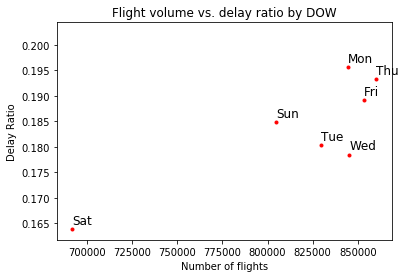

In [132]:
fig, ax = plt.subplots(figsize=(6, 4))
for i, dow in enumerate(delayed_by_dow.index.values):
    x = delayed_by_dow.at[dow, 'total']
    y = delayed_by_dow.at[dow, 'delay_ratio']
    ax.scatter(x, y, marker='.', color='red')
    ax.text(x + 100, y + 0.001, dow, fontsize=12)
    ax.set_xlabel('Number of flights')
    ax.set_ylabel('Delay Ratio')
    ax.set_title('Flight volume vs. delay ratio by DOW')

In [125]:
df_airlines = pd.read_csv(DATA_PATH / 'lookups' / 'airline_lookups.csv', index_col='AirlineID')
delayed_by_airline = pd.DataFrame(df.groupby(['DOT_ID_Reporting_Airline', 'DepartureIsDelayed']).size()).unstack(level=1)
delayed_by_airline.columns = ['not_delayed', 'delayed']
delayed_by_airline['total'] = delayed_by_airline.sum(axis=1)
delayed_by_airline['delay_ratio'] = delayed_by_airline['delayed'] / delayed_by_airline['total']
delayed_by_airline['airline_code'] = delayed_by_airline.index.map(df_airlines['Description'])
delayed_by_airline = delayed_by_airline.set_index('airline_code')

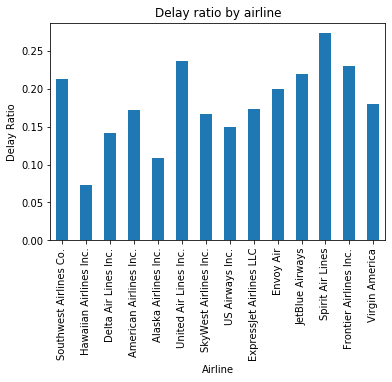

In [131]:
fig = plt.figure(figsize=(6, 4))
ax = delayed_by_airline['delay_ratio'].plot(kind='bar', title='', fig=fig)
ax.set_xlabel('Airline')
ax.set_ylabel('Delay Ratio')
_ = ax.set_title('Delay ratio by airline')